In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
# Leer archivos CSV
calendar = pd.read_csv('m5-forecasting-accuracy/calendar.csv')
sales_train_val = pd.read_csv('m5-forecasting-accuracy/sales_train_validation.csv')
sell_prices = pd.read_csv('m5-forecasting-accuracy/sell_prices.csv')

In [4]:
# Verificar valores nulos y rellenarlos con N/A
print(calendar.isnull().sum())
calendar.fillna('N/A', inplace=True)

# Convertir la columna 'd' para que tenga el tipo de dato entero
calendar['d'] = calendar['d'].str.replace('d_', '').astype(int)
print(calendar.dtypes)
calendar.head()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64
date            object
wm_yr_wk         int64
weekday         object
wday             int64
month            int64
year             int64
d                int32
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA          int64
snap_TX          int64
snap_WI          int64
dtype: object


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,1,N/A,N/A,N/A,N/A,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,2,N/A,N/A,N/A,N/A,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,3,N/A,N/A,N/A,N/A,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,4,N/A,N/A,N/A,N/A,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,5,N/A,N/A,N/A,N/A,1,0,1


In [5]:
# Revisar si hay valores nulos
nulos = sales_train_val.isnull().sum().sum()
print(f"Valores nulos en sales_train_val: {nulos}")  # Debería ser 0

Valores nulos en sales_train_val: 0


In [6]:
# Revisar valores nulos
print(sell_prices.isnull().sum())

# Revisar estadísticos descriptivos de los precios
print(sell_prices['sell_price'].describe())

# Asegurarse de que 'wm_yr_wk' es int y 'sell_price' es float
sell_prices['wm_yr_wk'] = sell_prices['wm_yr_wk'].astype(int)
sell_prices['sell_price'] = sell_prices['sell_price'].astype(float)

# Verificar el resultado
sell_prices.head()


store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64
count    6.841121e+06
mean     4.410952e+00
std      3.408814e+00
min      1.000000e-02
25%      2.180000e+00
50%      3.470000e+00
75%      5.840000e+00
max      1.073200e+02
Name: sell_price, dtype: float64


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [7]:
# Cantidad de filas y columnas de cada tabla
print("sales_train_val:", sales_train_val.shape)
print("calendar:", calendar.shape)
print("sell_prices:", sell_prices.shape)

sales_train_val: (30490, 1919)
calendar: (1969, 14)
sell_prices: (6841121, 4)


In [33]:
# Preparar los datos para unir con calendario
ventas_long = sales_train_val.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                                   var_name='d', 
                                   value_name='sales')
ventas_long['d'] = ventas_long['d'].str.replace('d_', '').astype(int)
calendar['d'] = calendar['d'].astype(int)

# Realizar el merge incluyendo información completa de eventos
ventas_long = pd.merge(
    ventas_long, 
    calendar[['d', 'wm_yr_wk', 'weekday', 'month', 'year', 
              'event_name_1', 'event_type_1', 
              'event_name_2', 'event_type_2', 
              'snap_CA', 'snap_TX', 'snap_WI']], 
    on='d', 
    how='left'
)


# Unir ventas_long con sell_prices usando las columnas clave comunes
ventas_completa = pd.merge(
    ventas_long, 
    sell_prices, 
    on=['store_id', 'item_id', 'wm_yr_wk'], 
    how='left'
)

# Verificar la forma y las columnas de la tabla resultante
print("ventas_completa:", ventas_completa.shape)
print(ventas_completa.columns)


ventas_completa: (0, 15)
Index(['id', 'sales', 'd', 'weekday', 'month', 'year', 'event_name_1',
       'event_type_1', 'snap_CA', 'snap_TX', 'snap_WI', 'store_id', 'item_id',
       'wm_yr_wk', 'sell_price'],
      dtype='object')


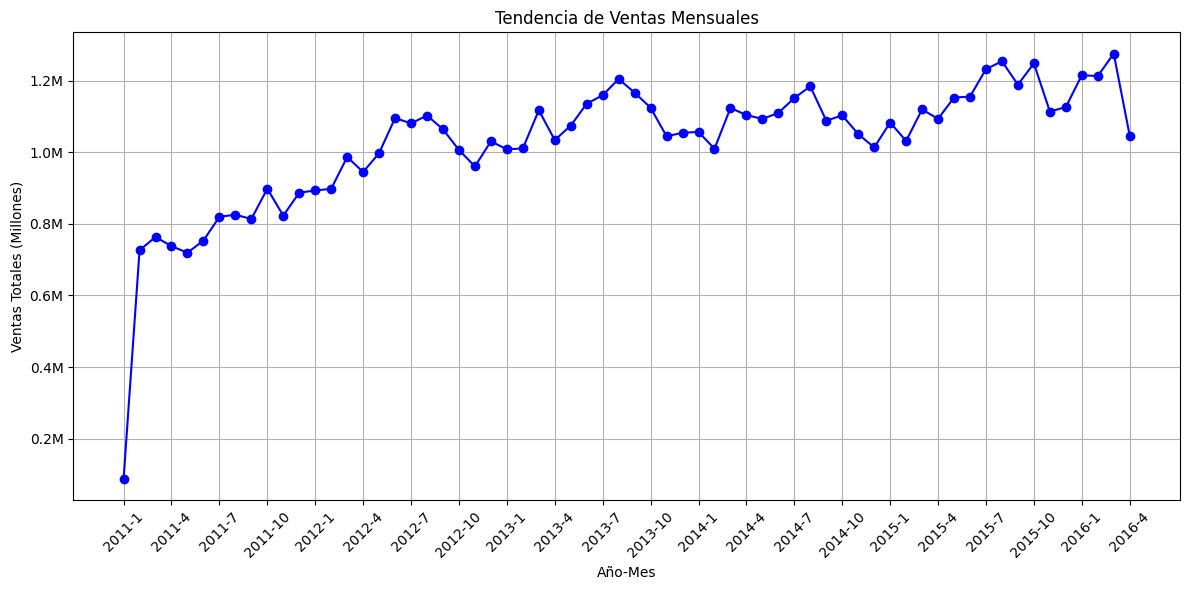

In [24]:
# Agrupar por año y mes
ventas_por_mes = ventas_long.groupby(['year', 'month']).agg({'sales': 'sum'}).reset_index()

# Crear una nueva columna para el eje X combinando año y mes
ventas_por_mes['year_month'] = ventas_por_mes['year'].astype(str) + '-' + ventas_por_mes['month'].astype(str)

# Graficar usando el nuevo eje X con mejoras visuales
plt.figure(figsize=(12, 6))
plt.plot(ventas_por_mes['year_month'], ventas_por_mes['sales'], marker='o', color='blue')
plt.title('Tendencia de Ventas Mensuales')
plt.xlabel('Año-Mes')
plt.ylabel('Ventas Totales (Millones)')

# Ajustar formato del eje Y para mostrar en millones sin el problema de "0M"
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 1e-6:.1f}M'))  # Multiplicar por 1e-6 para convertir a millones

# Ajustar etiquetas del eje X para que sean menos densas
plt.xticks(ventas_por_mes['year_month'][::3], rotation=45)  # Mostrar solo una etiqueta cada 3 meses

# Añadir líneas guía
plt.grid(True)
plt.tight_layout()
plt.show()


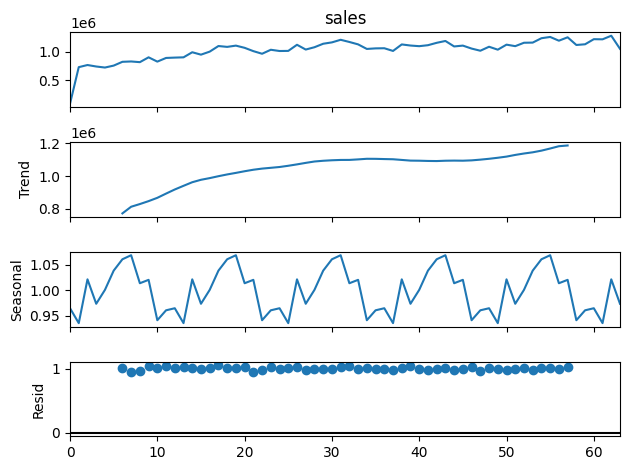

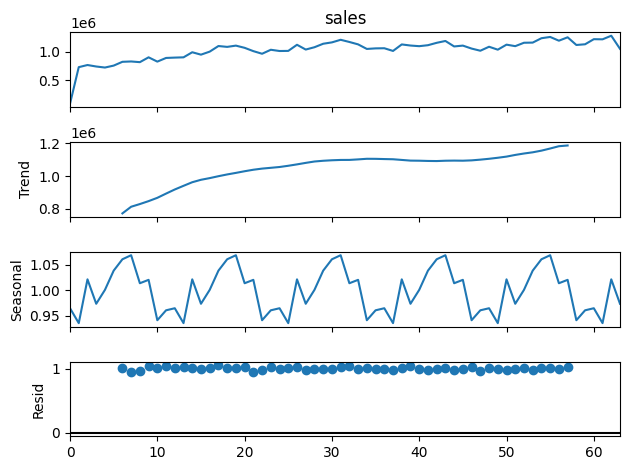

In [26]:
# Usar la librería statsmodels para descomponer la serie temporal
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponer las ventas totales a nivel mensual
result = seasonal_decompose(ventas_por_mes['sales'], model='multiplicative', period=12)
result.plot()

In [27]:
# Usar Prophet para el pronóstico
from fbprophet import Prophet
df_prophet = ventas_por_mes.rename(columns={'year_month': 'ds', 'sales': 'y'})
model = Prophet(yearly_seasonality=True, weekly_seasonality=False)
model.fit(df_prophet)
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)
model.plot(forecast)


ModuleNotFoundError: No module named 'fbprophet'